<a href="https://colab.research.google.com/github/sakunisgithub/machine_learning/blob/master/0004_FeedForward_Neural_Network_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective

Here I take on $\textbf{MNIST Handwritten Digits}$ dataset and build a fully connected $\textbf{FeedForward Neural Network from scratch}$ with self implementation of

$\bullet$ Forward Propagation,

$\bullet$ Backward Propagation,

$\bullet$ Gradient Descent.

# The Math

<img src = "https://raw.githubusercontent.com/sakunisgithub/data_sets/refs/heads/master/backpropagation.jpg">

# Necessary Imports

In [ ]:
import numpy as np
import cupy as cp

from matplotlib import pyplot as plt

import tensorflow as tf # for loading data

# Loading the data

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
print(f"Train images : {x_train.shape}")
print(f"Train labels : {y_train.shape}")

print(f"Test images : {x_test.shape}")
print(f"Test labels : {y_test.shape}")

Train images : (60000, 28, 28)
Train labels : (60000,)
Test images : (10000, 28, 28)
Test labels : (10000,)


# Hovering over the data

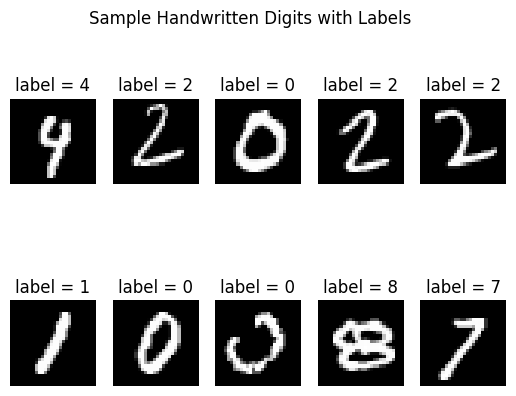

In [ ]:
index = np.random.randint(low = 0, high = 60000, size = 10)

fig, axes = plt.subplots(2, 5)

for i, ax in enumerate(axes.flat) :
  ax.imshow(x_train[index[i]], cmap = "gray")
  ax.axis('off')
  ax.set_title(f"label = {y_train[index[i]]}")

fig.suptitle("Sample Handwritten Digits with Labels")

plt.show()

In [ ]:
X = x_train.reshape(60000, 784).T / np.max(x_train)
X = cp.array(X)
print(X.shape)

(784, 60000)


In [ ]:
n, m = X.shape

# Some Preliminaries

## Activation Function and its derivative

In [ ]:
def ReLU(x) :
  return cp.maximum(0, x)

In [ ]:
def ReLU_dash(x) :
  return cp.array(x > 0, dtype = cp.int8)

## Output Function

In [ ]:
def Softmax(x):
    exp_shifted = cp.exp(x - cp.max(x, axis=0, keepdims=True))
    return exp_shifted / cp.sum(exp_shifted, axis=0, keepdims=True)

## One-hot encoding

In [ ]:
def one_hot(x) :
  return cp.array(cp.arange(10) == x, dtype = cp.int8)

In [ ]:
train_labels = cp.empty((10, 60000))

for i in range(60000) :
  train_labels[:, i] = one_hot(y_train[i])

# Parameter Initialization

$\spadesuit$ We construct a neural network with

$\bullet$ an $\textbf{input layer}$ with 784 neurones,

$\bullet$ $\textbf{two hidden layers}$ with 500 and 150 neurones respectively,

$\bullet$ an $\textbf{output layer}$ with 10 neurones.



$\bullet$ At the hidden layers, $\textbf{ReLU}$ is used as an activation function,

$\bullet$ At the output layer, $\textbf{Softmax}$ is used as activation function.

$\bullet$ $\textbf{Average Sparse Categorical Cross-Entropy}$ is the loss function here.

In [ ]:
def init_params() :
  W1 = cp.random.randn(500, 784) * 0.01
  b1 = cp.zeros((500, 1))

  W2 = cp.random.randn(150, 500) * 0.01
  b2 = cp.zeros((150, 1))

  W3 = cp.random.randn(10, 150) * 0.01
  b3 = cp.zeros((10, 1))

  return W1, b1, W2, b2, W3, b3

# Forward Propagation

In [ ]:
def forward_propagation(W1, b1, W2, b2, W3, b3, X) :
  A1 = cp.dot(W1, X) + b1
  H1 = ReLU(A1)

  A2 = cp.dot(W2, H1) + b2
  H2 = ReLU(A2)

  A3 = cp.dot(W3, H2) + b3
  H3 = Softmax(A3)

  return A1, H1, A2, H2, A3, H3

# Backward Propagation

In [ ]:
def backward_propagation(W1, b1, W2, b2, W3, b3, Y_hat, A1, A2, H1, H2, A3, H3, X, train_labels) :
  # output layer
  d_A3 = (Y_hat - train_labels) / m

  d_W3 = cp.dot(d_A3, H2.T)
  d_b3 = cp.sum(d_A3, axis=1, keepdims=True)

  # hidden layer 2
  d_H2 = cp.dot(W3.T, d_A3)

  d_A2 = d_H2 * ReLU_dash(A2)

  d_W2 = cp.dot(d_A2, H1.T)
  d_b2 = cp.sum(d_A2, axis=1, keepdims=True)

  # hidden layer 1
  d_H1 = cp.dot(W2.T, d_A2)

  d_A1 = d_H1 * ReLU_dash(A1)

  d_W1 = cp.dot(d_A1, X.T)
  d_b1 = cp.sum(d_A1, axis=1, keepdims=True)

  return d_W1, d_b1, d_W2, d_b2, d_W3, d_b3

# Gradient Descent

In [ ]:
def gradient_descent(iterations, eta) :

  t = iterations

  W1, b1, W2, b2, W3, b3 = init_params()

  i = 1

  while(i <= t) :
    # forward propagation
    A1, H1, A2, H2, A3, H3 = forward_propagation(W1, b1, W2, b2, W3, b3, X)

    Y_hat = H3

    # backward propagation
    d_W1, d_b1, d_W2, d_b2, d_W3, d_b3 = backward_propagation(W1, b1, W2, b2, W3, b3, Y_hat, A1, A2, H1, H2, A3, H3, X, train_labels)

    # update parameters
    W1 = W1 - eta * d_W1
    W2 = W2 - eta * d_W2
    W3 = W3 - eta * d_W3

    b1 = b1 - eta * d_b1
    b2 = b2 - eta * d_b2
    b3 = b3 - eta * d_b3

    i = i + 1

    if(i % 10 == 0) :
      loss = -cp.mean(cp.sum(train_labels * cp.log(Y_hat + 1e-8), axis=0))
      print(f"Iteration {i}, Loss: {loss:.4f}")

  return W1, b1, W2, b2, W3, b3

# Model Training

In [ ]:
W1, b1, W2, b2, W3, b3 = gradient_descent(iterations=1000, eta=0.1)

Iteration 10, Loss: 2.3020
Iteration 20, Loss: 2.3013
Iteration 30, Loss: 2.3007
Iteration 40, Loss: 2.3000
Iteration 50, Loss: 2.2993
Iteration 60, Loss: 2.2984
Iteration 70, Loss: 2.2974
Iteration 80, Loss: 2.2961
Iteration 90, Loss: 2.2944
Iteration 100, Loss: 2.2921
Iteration 110, Loss: 2.2889
Iteration 120, Loss: 2.2843
Iteration 130, Loss: 2.2772
Iteration 140, Loss: 2.2660
Iteration 150, Loss: 2.2470
Iteration 160, Loss: 2.2146
Iteration 170, Loss: 2.1622
Iteration 180, Loss: 2.0902
Iteration 190, Loss: 1.9987
Iteration 200, Loss: 1.8743
Iteration 210, Loss: 1.7151
Iteration 220, Loss: 1.5459
Iteration 230, Loss: 1.3899
Iteration 240, Loss: 1.2518
Iteration 250, Loss: 1.1238
Iteration 260, Loss: 1.0097
Iteration 270, Loss: 0.9187
Iteration 280, Loss: 0.8507
Iteration 290, Loss: 0.7999
Iteration 300, Loss: 0.7605
Iteration 310, Loss: 0.7287
Iteration 320, Loss: 0.7019
Iteration 330, Loss: 0.6785
Iteration 340, Loss: 0.6575
Iteration 350, Loss: 0.6381
Iteration 360, Loss: 0.6200
I

# Accuracy

In [ ]:
def get_predictions(x):
    return cp.argmax(x, axis=0)

def get_accuracy(predictions, Y):
    return cp.mean(predictions == Y) * 100

In [ ]:
A1_test, H1_test, A2_test, H2_test, A3_test, H3_test = forward_propagation(W1, b1, W2, b2, W3, b3, cp.array(x_test.reshape(10000, 784)).T)

# H3_test to get predictions
predictions = get_predictions(H3_test)

accuracy = get_accuracy(predictions, cp.array(y_test))
print("Test set accuracy: {:.2f}%".format(accuracy))

Test set accuracy: 90.95%
